# Berlin Airbnb housing prices

## 1. Import required library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import geopy.distance
import geopandas as gpd
import geoplot

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## 2. Data Understanding

### 2.1 Read data with pandas

In [2]:
df = pd.read_csv('../input/airbnb-berlin-july-2021/listings_berlin.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1944,bright & airy Pberg/Mitte 3 months or more,2164,Lulah,Mitte,Brunnenstr. Nord,52.54433,13.39761,Private room,28,60,18,2018-11-11,0.21,3,101
1,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ion,Mitte,Brunnenstr. Süd,52.53305,13.40394,Entire home/apt,74,90,141,2020-04-03,2.20,6,357
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53471,13.41810,Entire home/apt,90,62,147,2017-03-20,1.14,1,254
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.49884,13.34940,Private room,29,7,27,2018-08-16,0.28,1,285
4,6883,Stylish East Side Loft in Center with AC & 2 b...,16149,Steffen,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.51163,13.45289,Entire home/apt,79,7,135,2021-01-02,1.02,1,0


### 2.2 Explore Dataset Information

In [3]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19095 entries, 0 to 19094
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19095 non-null  int64  
 1   name                            19065 non-null  object 
 2   host_id                         19095 non-null  int64  
 3   host_name                       19083 non-null  object 
 4   neighbourhood_group             19095 non-null  object 
 5   neighbourhood                   19095 non-null  object 
 6   latitude                        19095 non-null  float64
 7   longitude                       19095 non-null  float64
 8   room_type                       19095 non-null  object 
 9   price                           19095 non-null  int64  
 10  minimum_nights                  19095 non-null  int64  
 11  number_of_reviews               19095 non-null  int64  
 12  last_review                     

In [4]:
# check dataset shape
df.shape

(19095, 16)

In [5]:
# describe numeric column
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,1.909500e+04,1.909500e+04,19095.000000,19095.000000,19095.000000,19095.000000,19095.000000,14940.000000,19095.000000,19095.000000
mean,2.512174e+07,9.302362e+07,52.510215,13.404654,73.303221,9.105944,21.637078,0.718274,3.135847,91.271694
std,1.492085e+07,1.071839e+08,0.032391,0.062953,136.249622,33.635956,48.670427,1.445272,7.773246,127.645330
min,1.944000e+03,1.581000e+03,52.340070,13.097150,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,1.222209e+07,1.180492e+07,52.489710,13.367160,35.000000,2.000000,1.000000,0.090000,1.000000,0.000000
50%,2.364643e+07,4.377035e+07,52.509950,13.414090,52.000000,3.000000,4.000000,0.270000,1.000000,0.000000
75%,3.886012e+07,1.445742e+08,52.533320,13.438900,81.000000,5.000000,17.000000,0.830000,2.000000,175.000000
max,5.098337e+07,4.120595e+08,52.656110,13.757370,8000.000000,1124.000000,620.000000,94.350000,76.000000,365.000000


## 3. Exploratory Data Analysis (EDA)

### 3.1 Check and remove missing values

In [6]:
# check missing values
df.isna().sum()

id                                   0
name                                30
host_id                              0
host_name                           12
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       4155
reviews_per_month                 4155
calculated_host_listings_count       0
availability_365                     0
dtype: int64

In [7]:
# remove rows in column that have missing value
misvalue = ['last_review', 'reviews_per_month', 'name', 'host_name']

for column in misvalue:
    for index in df[df[column].isna()].index:
        df.drop(index, axis=0, inplace=True)

In [8]:
# recheck dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14917 entries, 0 to 19033
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14917 non-null  int64  
 1   name                            14917 non-null  object 
 2   host_id                         14917 non-null  int64  
 3   host_name                       14917 non-null  object 
 4   neighbourhood_group             14917 non-null  object 
 5   neighbourhood                   14917 non-null  object 
 6   latitude                        14917 non-null  float64
 7   longitude                       14917 non-null  float64
 8   room_type                       14917 non-null  object 
 9   price                           14917 non-null  int64  
 10  minimum_nights                  14917 non-null  int64  
 11  number_of_reviews               14917 non-null  int64  
 12  last_review                     

In [9]:
df.shape

(14917, 16)

### 3.2 Target analysis

In [10]:
# remove outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['price']<(Q1-1.5*IQR))|(df['price']>(Q3+1.5*IQR)))]
df.reset_index(drop=True)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1944,bright & airy Pberg/Mitte 3 months or more,2164,Lulah,Mitte,Brunnenstr. Nord,52.544330,13.397610,Private room,28,60,18,2018-11-11,0.21,3,101
1,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ion,Mitte,Brunnenstr. Süd,52.533050,13.403940,Entire home/apt,74,90,141,2020-04-03,2.20,6,357
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534710,13.418100,Entire home/apt,90,62,147,2017-03-20,1.14,1,254
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.498840,13.349400,Private room,29,7,27,2018-08-16,0.28,1,285
4,6883,Stylish East Side Loft in Center with AC & 2 b...,16149,Steffen,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.511630,13.452890,Entire home/apt,79,7,135,2021-01-02,1.02,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13864,50750288,Kid friendly beautiful Vintage Place nearby a ...,47130862,Nora,Treptow - Köpenick,Friedrichshagen,52.455502,13.626311,Entire home/apt,120,2,1,2021-07-11,1.00,1,51
13865,50789984,K39 R2 / Private Room in Central City West,116125052,Frank,Charlottenburg-Wilm.,Schloß Charlottenburg,52.512610,13.291590,Private room,38,1,1,2021-07-06,1.00,2,180
13866,50820921,Beautiful room in Neukölln,327396350,Ina,Neukölln,Rixdorf,52.473364,13.452393,Private room,14,1,3,2021-07-09,3.00,2,0
13867,50863710,Spacious Bright Flat at Famous Mauerpark,229089748,Nikola,Pankow,Prenzlauer Berg Nordwest,52.548104,13.407948,Entire home/apt,99,3,1,2021-07-11,1.00,1,44


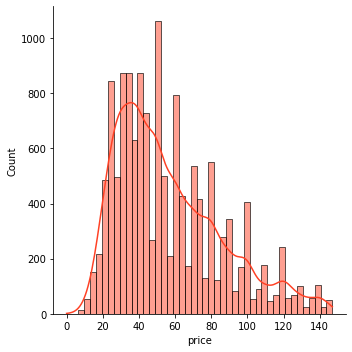

In [11]:
# anayze the target variable ie 'price'
sns.displot(data=df, x='price',color='#ff4125', kde=True)

### 3.3 Feature engineering

#### 3.3.1 Add new feature which is distance to city center

The value of a property generally increases the more central it is. So including the distance to the center of the city may be beneficial. I proxied the city centre by using the coordinates for the Mitte borough, which is the center of Berlin.

In [12]:
# center of Berlin city, Mitte borough
center = (52.5373, 13.3603)

In [13]:
df['dist_to_center'] = np.nan
for i in df.index:
    df['dist_to_center'][i] = geopy.distance.distance(center, (df['latitude'][i], df['longitude'][i])).km

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13869 entries, 0 to 19033
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13869 non-null  int64  
 1   name                            13869 non-null  object 
 2   host_id                         13869 non-null  int64  
 3   host_name                       13869 non-null  object 
 4   neighbourhood_group             13869 non-null  object 
 5   neighbourhood                   13869 non-null  object 
 6   latitude                        13869 non-null  float64
 7   longitude                       13869 non-null  float64
 8   room_type                       13869 non-null  object 
 9   price                           13869 non-null  int64  
 10  minimum_nights                  13869 non-null  int64  
 11  number_of_reviews               13869 non-null  int64  
 12  last_review                     

#### 3.3.2 Separate DataFrame depending on datatype

**Categorical features**

In [15]:
cat_df = df.select_dtypes(include='object')

In [16]:
catcol = list(cat_df.columns)
catcol

['name',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'room_type',
 'last_review']

**Numerical features**

In [17]:
num_df = df.select_dtypes(include='number')

In [18]:
numcol = list(num_df.columns)
numcol

['id',
 'host_id',
 'latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'dist_to_center']

#### 3.3.3 Univariate Analysis

In this section the univariate analysis is performed; More importantly I have considered the features that are more importanht with the 'Target' that have high corelation with the Target.

For the numeric features, I used 'displot' and 'boxplot' to analyze their distribution.

Similarly for categorical features the most reasonable way to visualize the distribution is to use a 'countplot' which shows the relative counts for each category or class. Can use a pie-plot also to be a bit more fancy.

**Numeric feature**

Analyze numeric features

In [19]:
# function to plot numerical feature
def plot_num(feature):
    sns.histplot(data=df,x=feature,color='#ff4125')

In [20]:
# check minimum nights feature
df['minimum_nights'].unique()

array([  60,   90,   62,    7,    1,    5,    2,  185,    4,    3,   10,
         84,   15,   82,    8,   70,  183,  180,   45,   28,    6,   30,
         91,   63,   22,   93,   25,   21,   61,   14,   20,  122, 1000,
         29,  150,   56,  181,  118,   89,  200,   40,  356,   80, 1100,
         31,   13,   85,   42,  300,   59,   27, 1124,   55,  120,  100,
         18,   35,   34,   47,   33,   92,   12,   16,  500,   65,   19,
        119,   24,    9,   68,  105,   58,   50,   38,   75,   11,  304,
         51,  240,   32,  112,  170,  182,  187,   23,  720,  360,   26])

In [21]:
# count the sum of every unique element
Counter(df['minimum_nights']).most_common()

[(2, 3506),
 (1, 2946),
 (3, 2709),
 (4, 1096),
 (5, 1009),
 (7, 589),
 (30, 303),
 (6, 280),
 (10, 218),
 (14, 206),
 (60, 194),
 (90, 115),
 (28, 67),
 (20, 65),
 (8, 51),
 (21, 47),
 (12, 43),
 (180, 36),
 (15, 33),
 (13, 28),
 (61, 27),
 (9, 23),
 (25, 21),
 (22, 18),
 (31, 16),
 (62, 15),
 (29, 15),
 (40, 10),
 (183, 9),
 (91, 9),
 (93, 9),
 (45, 8),
 (120, 8),
 (27, 7),
 (100, 7),
 (18, 7),
 (150, 6),
 (89, 6),
 (56, 5),
 (181, 5),
 (300, 5),
 (58, 5),
 (1000, 4),
 (200, 4),
 (80, 4),
 (85, 4),
 (19, 4),
 (50, 4),
 (84, 3),
 (70, 3),
 (63, 3),
 (118, 3),
 (1124, 3),
 (55, 3),
 (35, 3),
 (185, 2),
 (59, 2),
 (33, 2),
 (92, 2),
 (16, 2),
 (500, 2),
 (65, 2),
 (24, 2),
 (11, 2),
 (82, 1),
 (122, 1),
 (356, 1),
 (1100, 1),
 (42, 1),
 (34, 1),
 (47, 1),
 (119, 1),
 (68, 1),
 (105, 1),
 (38, 1),
 (75, 1),
 (304, 1),
 (51, 1),
 (240, 1),
 (32, 1),
 (112, 1),
 (170, 1),
 (182, 1),
 (187, 1),
 (23, 1),
 (720, 1),
 (360, 1),
 (26, 1)]

In [22]:
# remove element with value less than 365
df = df[~(df['minimum_nights'] > 365)]

In [23]:
df.shape

(13858, 17)

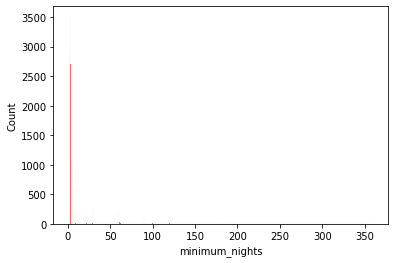

In [24]:
# plot minimum nights feature
plot_num('minimum_nights')

Majority of the airbnb housing have low minimum nights to rent

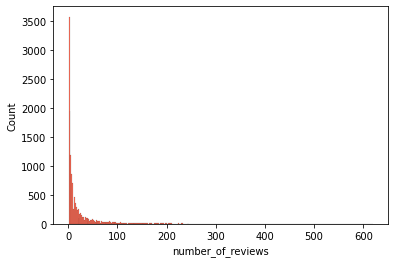

In [25]:
# check number of reviews feature
plot_num('number_of_reviews')

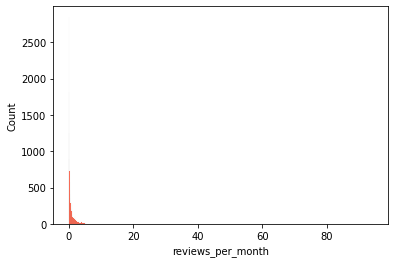

In [26]:
# check reviews per month feature
plot_num('reviews_per_month')

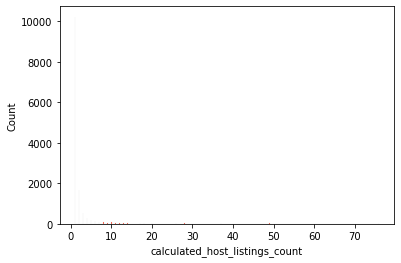

In [27]:
# check calculated host listings count feature
plot_num('calculated_host_listings_count')

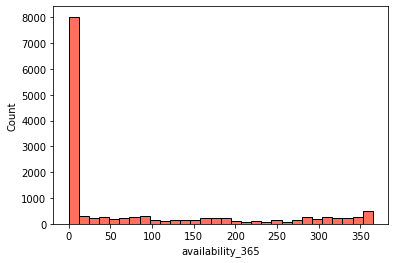

In [28]:
# check availability 365 feature
plot_num('availability_365')

In [29]:
# using geopandas to read geojson file
berlin = gpd.read_file('../input/airbnb-berlin-july-2021/neighbourhoods.geojson')

/opt/conda/lib/python3.7/site-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


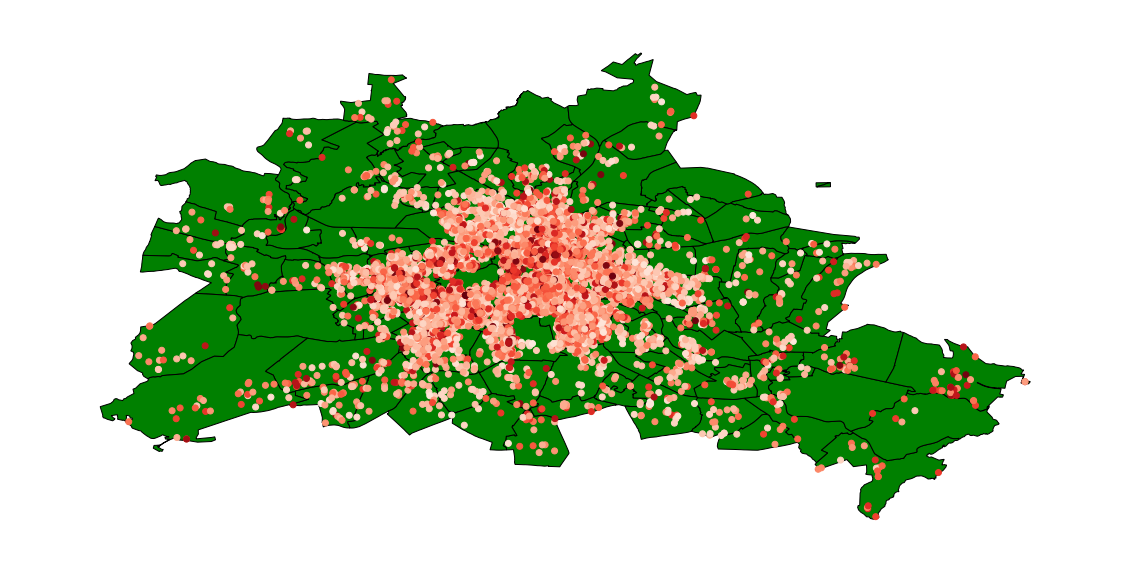

In [30]:
# create geoplot for berlin city map
geoplot.polyplot(berlin, facecolor = 'green', figsize=(20, 20)) 
plt.scatter(df['longitude'], df['latitude'], c=df['price'], cmap = 'Reds')

The center the location, the higher the price and the amount of airbnb housing

**Categorical features**

Analyze categorical features

In [31]:
# function to visualize categorical data
def plot_cat(feature):
    sns.countplot(data=df,x=feature)
    ax=sns.countplot(data=df,x=feature)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=270)

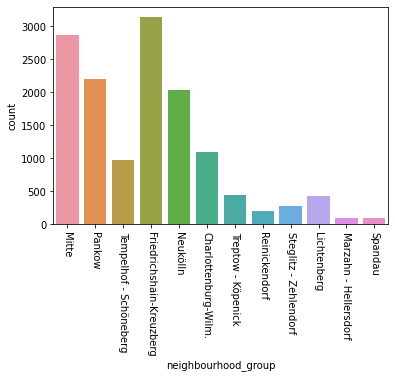

In [32]:
plot_cat('neighbourhood_group')

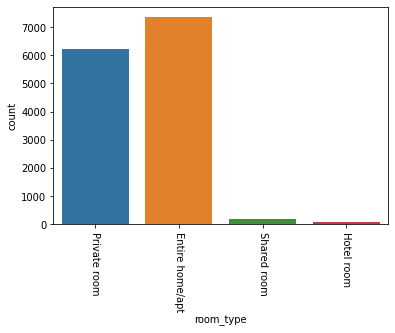

In [33]:
plot_cat('room_type')

#### 3.3.4 Bivariate analysis

In this section the Bivariate Analysis have been done. I have plotted various numeric as well as categorical features against the target ie 'SalePrice'.

**Numerical features**

In [34]:
# function to visualize bivariate analysis for numerical feature
def bi_num(feature):
    fig, ax = plt.subplots()
    ax.scatter(x = df[feature], y = df['price'])
    plt.ylabel('price')
    plt.xlabel(feature)
    plt.show()

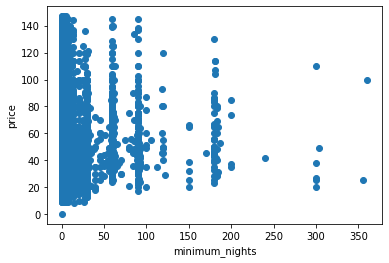

In [35]:
bi_num('minimum_nights')

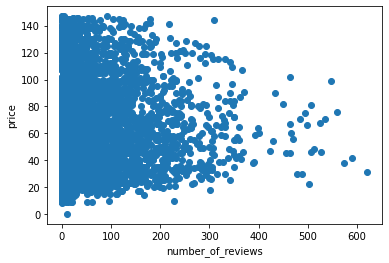

In [36]:
bi_num('number_of_reviews')

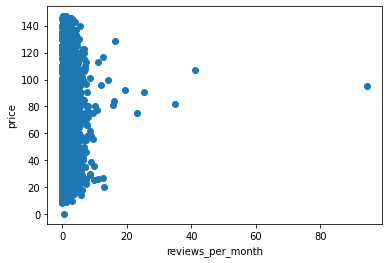

In [37]:
bi_num('reviews_per_month')

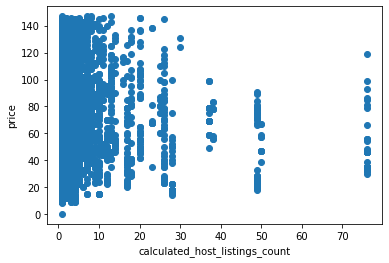

In [38]:
bi_num('calculated_host_listings_count')

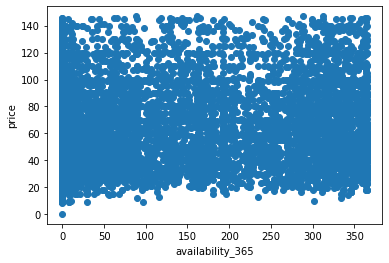

In [39]:
bi_num('availability_365')

From the numerical feature, we can conclude that those features is lessly correlated to the increase of the airbnb housing prices

**Categorical features**

In [40]:
# function to visualize bivariate analysis of the categorical feature
def bi_cat(feature):
    ax=sns.catplot(data=df,x=feature,y='price',kind='box',height=5,aspect=1.5)
    ax.set_xticklabels(rotation=270)

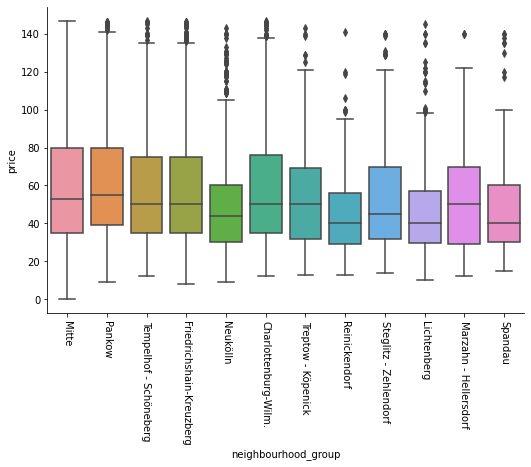

In [41]:
bi_cat('neighbourhood_group')

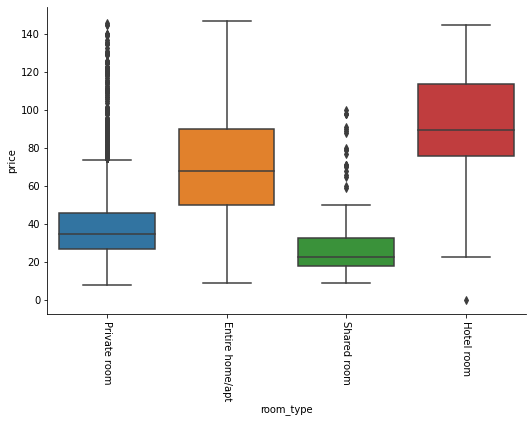

In [42]:
bi_cat('room_type')

Entire home/apartment and Hotel room have higher prices

#### 3.3.4 Most correlated feature to the target

In [43]:
cor_mat= df[:].corr()
cor_to_tar=cor_mat.sort_values(['price'],ascending=False)

In [44]:
print("The most relevant features (numeric) for the target are :")
cor_to_tar.price

The most relevant features (numeric) for the target are :


price                             1.000000
availability_365                  0.221269
reviews_per_month                 0.109088
number_of_reviews                 0.096458
calculated_host_listings_count    0.058577
id                                0.043061
host_id                           0.037967
latitude                          0.036011
longitude                        -0.007902
minimum_nights                   -0.008879
dist_to_center                   -0.070384
Name: price, dtype: float64

The majority of the columns have low correlation to the price value. Even newly created column, the distance to center, has the lowest correlation to the price value.

## 4. Data Preparation

### 4.1 Select the feature

In [45]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,dist_to_center
0,1944,bright & airy Pberg/Mitte 3 months or more,2164,Lulah,Mitte,Brunnenstr. Nord,52.54433,13.39761,Private room,28,60,18,2018-11-11,0.21,3,101,2.649503
1,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ion,Mitte,Brunnenstr. Süd,52.53305,13.40394,Entire home/apt,74,90,141,2020-04-03,2.20,6,357,2.998764
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53471,13.41810,Entire home/apt,90,62,147,2017-03-20,1.14,1,254,3.932579
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.49884,13.34940,Private room,29,7,27,2018-08-16,0.28,1,285,4.343211
4,6883,Stylish East Side Loft in Center with AC & 2 b...,16149,Steffen,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.51163,13.45289,Entire home/apt,79,7,135,2021-01-02,1.02,1,0,6.903055


Drop the column id, name, host_id, host_name, neighbourhood, latitude, and longitude. Set the the name of the housing as index.

In [46]:
df.set_index('name', inplace=True)
df.head()

,id,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,dist_to_center
name,,,,,,,,,,,,,,,,
bright & airy Pberg/Mitte 3 months or more,1944,2164,Lulah,Mitte,Brunnenstr. Nord,52.54433,13.39761,Private room,28,60,18,2018-11-11,0.21,3,101,2.649503
Berlin-Mitte Value! Quiet courtyard/very central,2015,2217,Ion,Mitte,Brunnenstr. Süd,52.53305,13.40394,Entire home/apt,74,90,141,2020-04-03,2.20,6,357,2.998764
Fabulous Flat in great Location,3176,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53471,13.41810,Entire home/apt,90,62,147,2017-03-20,1.14,1,254,3.932579
BerlinSpot Schöneberg near KaDeWe,3309,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.49884,13.34940,Private room,29,7,27,2018-08-16,0.28,1,285,4.343211
Stylish East Side Loft in Center with AC & 2 bikes,6883,16149,Steffen,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.51163,13.45289,Entire home/apt,79,7,135,2021-01-02,1.02,1,0,6.903055


Separate target from the features

In [47]:
selected_features = ['neighbourhood_group', 'room_type', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'dist_to_center']

y = df['price']
df = df[selected_features]
df.head()

,neighbourhood_group,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_to_center
name,,,,,,,,
bright & airy Pberg/Mitte 3 months or more,Mitte,Private room,60,18,0.21,3,101,2.649503
Berlin-Mitte Value! Quiet courtyard/very central,Mitte,Entire home/apt,90,141,2.20,6,357,2.998764
Fabulous Flat in great Location,Pankow,Entire home/apt,62,147,1.14,1,254,3.932579
BerlinSpot Schöneberg near KaDeWe,Tempelhof - Schöneberg,Private room,7,27,0.28,1,285,4.343211
Stylish East Side Loft in Center with AC & 2 bikes,Friedrichshain-Kreuzberg,Entire home/apt,7,135,1.02,1,0,6.903055


In [48]:
df.shape

(13858, 8)

### 4.2 Normalize data

In [49]:
column_numeric = df.select_dtypes(include='number').keys()
column_numeric

Index(['minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'dist_to_center'],
      dtype='object')

In [50]:
scaler = MinMaxScaler()

In [51]:
scaled = scaler.fit_transform(df[column_numeric])

In [52]:
i=0
for column in column_numeric:
    df[column] = scaled[:,i]
    i += 1

In [53]:
df.head()

,neighbourhood_group,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_to_center
name,,,,,,,,
bright & airy Pberg/Mitte 3 months or more,Mitte,Private room,0.164345,0.027464,0.002120,0.026667,0.276712,0.087378
Berlin-Mitte Value! Quiet courtyard/very central,Mitte,Entire home/apt,0.247911,0.226171,0.023214,0.066667,0.978082,0.099265
Fabulous Flat in great Location,Pankow,Entire home/apt,0.169916,0.235864,0.011978,0.000000,0.695890,0.131047
BerlinSpot Schöneberg near KaDeWe,Tempelhof - Schöneberg,Private room,0.016713,0.042003,0.002862,0.000000,0.780822,0.145022
Stylish East Side Loft in Center with AC & 2 bikes,Friedrichshain-Kreuzberg,Entire home/apt,0.016713,0.216478,0.010706,0.000000,0.000000,0.232144


### 4.3 Convert categorical feature to numerical

In [54]:
df = pd.get_dummies(df)
df.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_to_center,neighbourhood_group_Charlottenburg-Wilm.,neighbourhood_group_Friedrichshain-Kreuzberg,neighbourhood_group_Lichtenberg,neighbourhood_group_Marzahn - Hellersdorf,...,neighbourhood_group_Pankow,neighbourhood_group_Reinickendorf,neighbourhood_group_Spandau,neighbourhood_group_Steglitz - Zehlendorf,neighbourhood_group_Tempelhof - Schöneberg,neighbourhood_group_Treptow - Köpenick,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
name,,,,,,,,,,,,,,,,,,,,,
bright & airy Pberg/Mitte 3 months or more,0.164345,0.027464,0.002120,0.026667,0.276712,0.087378,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Berlin-Mitte Value! Quiet courtyard/very central,0.247911,0.226171,0.023214,0.066667,0.978082,0.099265,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Fabulous Flat in great Location,0.169916,0.235864,0.011978,0.000000,0.695890,0.131047,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
BerlinSpot Schöneberg near KaDeWe,0.016713,0.042003,0.002862,0.000000,0.780822,0.145022,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
Stylish East Side Loft in Center with AC & 2 bikes,0.016713,0.216478,0.010706,0.000000,0.000000,0.232144,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13858 entries, bright & airy Pberg/Mitte 3 months or more to Elegant home at Brandenburg Gate for work/leisure
Data columns (total 22 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   minimum_nights                                13858 non-null  float64
 1   number_of_reviews                             13858 non-null  float64
 2   reviews_per_month                             13858 non-null  float64
 3   calculated_host_listings_count                13858 non-null  float64
 4   availability_365                              13858 non-null  float64
 5   dist_to_center                                13858 non-null  float64
 6   neighbourhood_group_Charlottenburg-Wilm.      13858 non-null  uint8  
 7   neighbourhood_group_Friedrichshain-Kreuzberg  13858 non-null  uint8  
 8   neighbourhood_group_Lichtenberg               13858 non-

### 4.4 Split train and test data

In [56]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=.2, shuffle=False)

In [57]:
print('X train shape  :', x_train.shape)
print('X test shape   :', x_test.shape)
print('Y train shape  :', y_train.shape)
print('Y test shape   :', y_test.shape)

X train shape  : (11086, 22)
X test shape   : (2772, 22)
Y train shape  : (11086,)
Y test shape   : (2772,)


## 5. Modeling
Lastly it is the time to apply various regression models and check how are we doing. I have used various regression models from the scikit.

Parameter tuning using GridSearchCV is also done to improve performance of some algos.

The evalauton metric that I have used is the Root Mean Squared Error between the 'Actual price' and 'Predicted price' which is also the evaluation metric used by the kaggle.

To get abetter idea one may also use the K-fold cross validation instead of the normal holdout set approach to cross validation.

### 5.1 Linear Regression

In [58]:
# fit linear regression model to train data
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [59]:
# predict test data
lrpred = lr.predict(x_test)

In [60]:
lr_mse = np.sqrt(mean_squared_error(y_test,lrpred))
lr_mse

24.16042918394222

### 5.2 Lasso and GridSearchCV Tuning

#### 5.2.1 Lasso Model

In [61]:
lasso=Lasso()
lasso.fit(x_train,y_train)

Lasso()

In [62]:
lassopred=lasso.predict(x_test)

In [63]:
lasso_mse = np.sqrt(mean_squared_error(y_test,lassopred))
lasso_mse

24.992867524238477

#### 5.2.2 Lasso GridSearchCV Tuning

In [64]:
params_dict={'alpha':[0.001, 0.005, 0.01,0.05,0.1,0.5,1]}
lasso_CV=GridSearchCV(estimator=Lasso(),param_grid=params_dict,scoring='neg_mean_squared_error',cv=10)
lasso_CV.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]},
             scoring='neg_mean_squared_error')

In [65]:
lassoCVpred = lasso_CV.predict(x_test)

In [66]:
lassoCV_mse = np.sqrt(mean_squared_error(y_test,lassoCVpred))
lassoCV_mse

24.128391033397012

### 5.3 Ridge Regression and GridSearchCV Tuning
#### 5.3.1 Ridge Regression Model

In [67]:
ridge=Ridge()
ridge.fit(x_train,y_train)

Ridge()

In [68]:
ridgepred = ridge.predict(x_test)

In [69]:
ridge_mse = np.sqrt(mean_squared_error(y_test,ridgepred))
ridge_mse

24.158105633348182

#### 5.3.2 Ridge Regression GridSearchCV Tuning

In [70]:
params_dict={'alpha':[0.1, 0.15, 0.20,0.25,0.30,0.35,0.4,0.45,0.50,0.55,0.60]}
ridge_CV=GridSearchCV(estimator=Ridge(),param_grid=params_dict,scoring='neg_mean_squared_error',cv=10)
ridge_CV.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,
                                   0.5, 0.55, 0.6]},
             scoring='neg_mean_squared_error')

In [71]:
ridgeCVpred = ridge_CV.predict(x_test)

In [72]:
ridgeCV_mse = np.sqrt(mean_squared_error(y_test,ridgeCVpred))
ridgeCV_mse

24.15756627882542

### 5.4 Gradient Boosting

In [73]:
gb=GradientBoostingRegressor()
gb.fit(x_train,y_train)

GradientBoostingRegressor()

In [74]:
gbpred = gb.predict(x_test)

In [75]:
gb_mse = np.sqrt(mean_squared_error(y_test,gbpred))
gb_mse

23.424100138398273

So far, Gradient Boosting Regressor has the minimum mse

## 6. Model Evaluation

In [76]:
result = pd.DataFrame({'Name': y_test.index, 'Actual Price': y_test.values, 'Predicted Price': gbpred})
result.head()

,Name,Actual Price,Predicted Price
0,Cosy quite Apartment Prenzlauer Berg,35,71.085047
1,Wundervolles Zimmer mitten in Berlin!!! 23m2,90,56.769116
2,"Amazing 2 room apartment, best host ever!",120,84.659819
3,Helles geräumiges Zimmer in Schöneberg/ nice room,28,34.328884
4,Double-bed Room with attached balcony (Neukölln),28,36.211139


From result above, we can say that the model hasn't reach a good outcome. Another model algorithm like Adaboost, RandomForest, etc. maybe better. The majority of the columns have low correlation to the price value. Even newly created column, the distance to center, has the lowest correlation to the price value. Other feature including amenities like bedroom count, beds count, maximum guest, swimming pool, wifi, air conditioning, gym, breakfast, etc. may affect the price even better. 